In [34]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [35]:
torch.manual_seed(0)

In [36]:
dataroot = "data/mnist"

workers = 10

batch_size = 100

image_size = 32

nc = 1

num_classes = 10

nz = 100

ngf = 64

ndf = 64

num_epochs = 10

lr = 0.0002

beta1 = 0.5

In [37]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')

Total Size of Dataset: 70000


In [38]:
dataloader = DataLoader (
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [39]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and 1 > 0) else 'cpu')

In [40]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

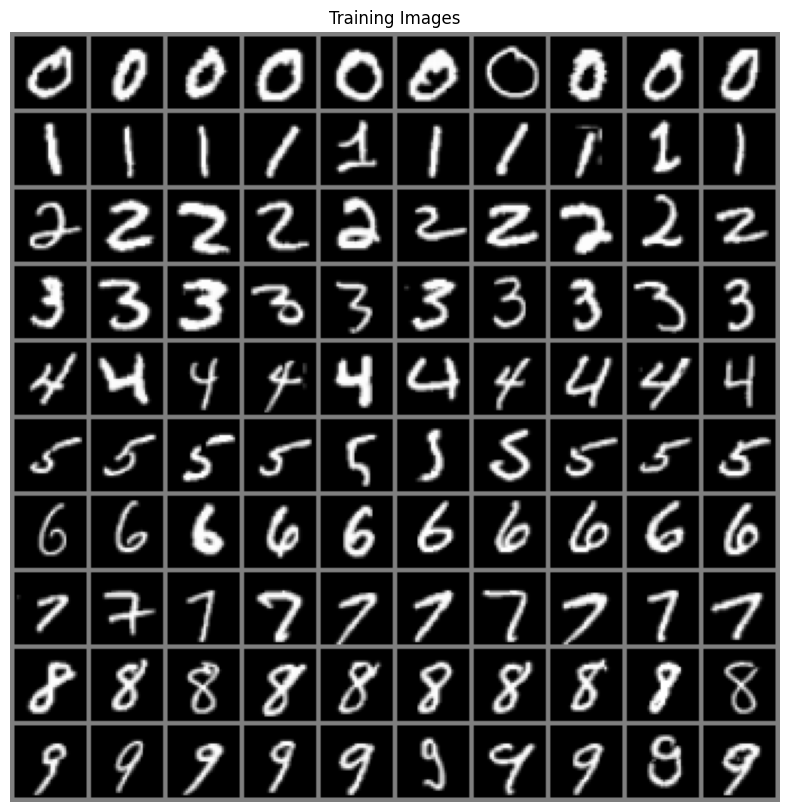

In [41]:
imgs = {}
for x, y in dataset:
    if y not in imgs:
        imgs[y] = []
    elif len(imgs[y])!=10:
        imgs[y].append(x)
    elif sum(len(imgs[key]) for key in imgs)==100:
        break
    else:
        continue
        
imgs = sorted(imgs.items(), key=lambda x:x[0])
imgs = [torch.stack(item[1], dim=0) for item in imgs]
imgs = torch.cat(imgs, dim=0)

plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.image = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True)
        )
        self.label = nn.Sequential(
            nn.ConvTranspose2d(10, 64 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64*2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [43]:
netG = Generator().to(device)

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.image = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.label = nn.Sequential(
            nn.Conv2d(10, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.main = nn.Sequential(
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [45]:
netD = Discriminator().to(device)

In [46]:
criterion = nn.BCEWithLogitsLoss()

real_label_num = 1.
fake_label_num = 0.

label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).to(device)

label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.to(device)

fixed_noise = torch.randn(100, nz, 1, 1).to(device)
fixed_label = label_1hots[torch.arange(10).repeat(10).sort().values]

In [47]:
import pytorch_lightning as pl

In [48]:
class CGAN(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.netD = netD
		self.netD.apply(weights_init)

		self.netG = netG
		self.netG.apply(weights_init)

		self.loss_tep = 100000

		self.automatic_optimization = False

	def forward(self, z, y):
		return self.netG(z, y)
	
	def configure_optimizers(self):
		g_optimizer = torch.optim.Adam(self.netG.parameters(), lr=0.0002)
		d_optimizer = torch.optim.Adam(self.netD.parameters(), lr=0.0002)
		return [g_optimizer, d_optimizer], []
	
	def training_step(self, batch, batch_idx):
		optimizerG, optimizerD = self.configure_optimizers()[0]

		data = batch
		i = batch_idx
		self.netD.zero_grad()
		
		real_image = data[0].to(device)
		b_size = real_image.size(0)

		real_label = torch.full((b_size,), real_label_num).to(device)
		fake_label = torch.full((b_size,), fake_label_num).to(device)
		
		G_label = label_1hots[data[1]]
		D_label = label_fills[data[1]]
		
		noise = torch.randn(b_size, nz, 1, 1).to(device)

		with torch.cuda.amp.autocast():
			fake = self.netG(noise, G_label)

		with torch.cuda.amp.autocast():
			output_real = self.netD(real_image, D_label).view(-1)
			errD_real = criterion(output_real, real_label)

			output_fake = self.netD(fake.detach(), D_label).view(-1)
			errD_fake = criterion(output_fake, fake_label)

		errD_real.backward()
		D_x = output_real.mean().item()

		errD_fake.backward()
		D_G_z1 = output_fake.mean().item()
		errD = errD_real + errD_fake
		optimizerD.step()

		self.netG.zero_grad()

		with torch.cuda.amp.autocast():        
			output = self.netD(fake, D_label).view(-1)
			errG = criterion(output, real_label)

		if errG < self.loss_tep:
			torch.save(self.netG.state_dict(), 'model.pt')
			loss_tep = errG

		errG.backward()
		D_G_z2 = output.mean().item()
		optimizerG.step()

		return errG - errD

In [49]:
model = CGAN()

trainer = pl.Trainer(max_epochs=10, accelerator="gpu", precision="16-mixed")
trainer.fit(model, dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | netD | Discriminator | 2.6 M 
1 | netG | Generator     | 3.1 M 
---------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.873    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


59.5 - Loss-D: 0.0828 Loss-G: 3.8640

1 11.9 - Loss-D: 0.0760 Loss-G: 3.9650          complile dont help (i can even see the difference in pics) much worse

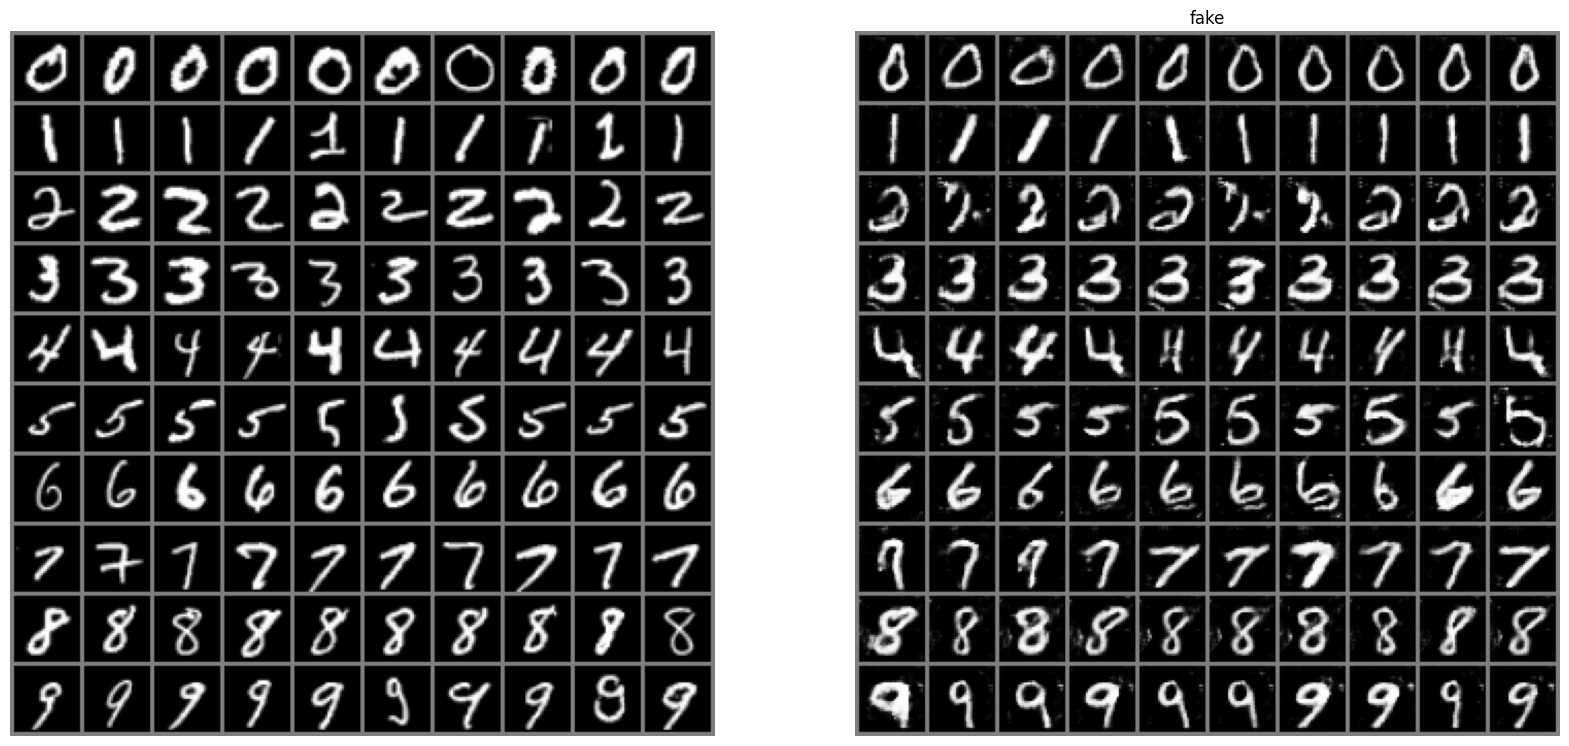

In [51]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis('off')
plt.title("")
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

netG = Generator()
netG.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
netG.eval()

with torch.no_grad():
    fake = netG(fixed_noise.cpu(), fixed_label.cpu())

plt.subplot(1,2,2)
plt.axis("off")
plt.title("fake")
fake = utils.make_grid(fake, nrow=10)
plt.imshow(fake.permute(1, 2, 0)*0.5+0.5)

plt.savefig('result.jpg', bbox_inches='tight')